Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
print('Length of words:', len(words))
print(words[:15])

Length of words: 17005207
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including']


Build the dictionary and replace rare words with UNK token.

In [5]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [6]:
print('Length of var count:', len(count))
print('Last word:', count[-1])

Length of var count 50000
Last word: ('thien', 9)


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    '''
    GENERATE_BATCH is to create batch dataset for training
      batch_size: size of batch to be returned
      num_skips: the number of times to reuse an input to generate a label
      skip_window: the number of words to consider left and right
    '''
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)  # limit the length of buffer within span
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['term', 'a', 'originated', 'anarchism', 'originated', 'of', 'term', 'as']


Train a skip-gram model.

In [7]:
# Settings
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64  # Number of negative examples to sample in softmax.
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [8]:
from time import time
num_steps = 100001

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
print('Elapsed training time:', time()-t0, 'seconds')

Initialized
Average loss at step 0: 7.988155
Nearest to united: imitations, serpents, confederations, procopius, utilised, knitters, maud, metalwork,
Nearest to not: split, hitpa, things, derivatives, simplicius, perception, introspection, fx,
Nearest to d: fluent, heels, pal, davidson, darpa, tarquin, george, immunoglobulin,
Nearest to use: taoiseach, tiamat, seem, telugu, animate, visceral, decorated, nic,
Nearest to b: chong, valerie, trainer, ias, washed, cigarette, idm, vainly,
Nearest to have: possibility, dingo, guderian, formalised, arin, japheth, calming, attractions,
Nearest to two: marca, earle, persona, silt, exercises, footnote, twentieth, buchan,
Nearest to see: effect, infogrames, derails, bacilli, informs, zealot, africaine, lethal,
Nearest to all: gules, inaccuracies, sisterhood, suckling, wolff, kiribati, virchow, turks,
Nearest to three: conciliator, insight, introducing, shoes, postcode, affect, dislocation, stimulus,
Nearest to or: kabila, worthy, symbiosis, sherpa

In [11]:
print(final_embeddings.shape)
print(final_embeddings.dtype)

(50000, 128)
float32


In [12]:
final_embeddings[0,:15]

array([ 0.01031726, -0.10972711, -0.16999169, -0.01937281, -0.04468733,
        0.0392909 ,  0.04748666, -0.03815879, -0.16337709,  0.25687709,
       -0.06804793, -0.06927781, -0.21419321, -0.11659118, -0.04825908], dtype=float32)

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

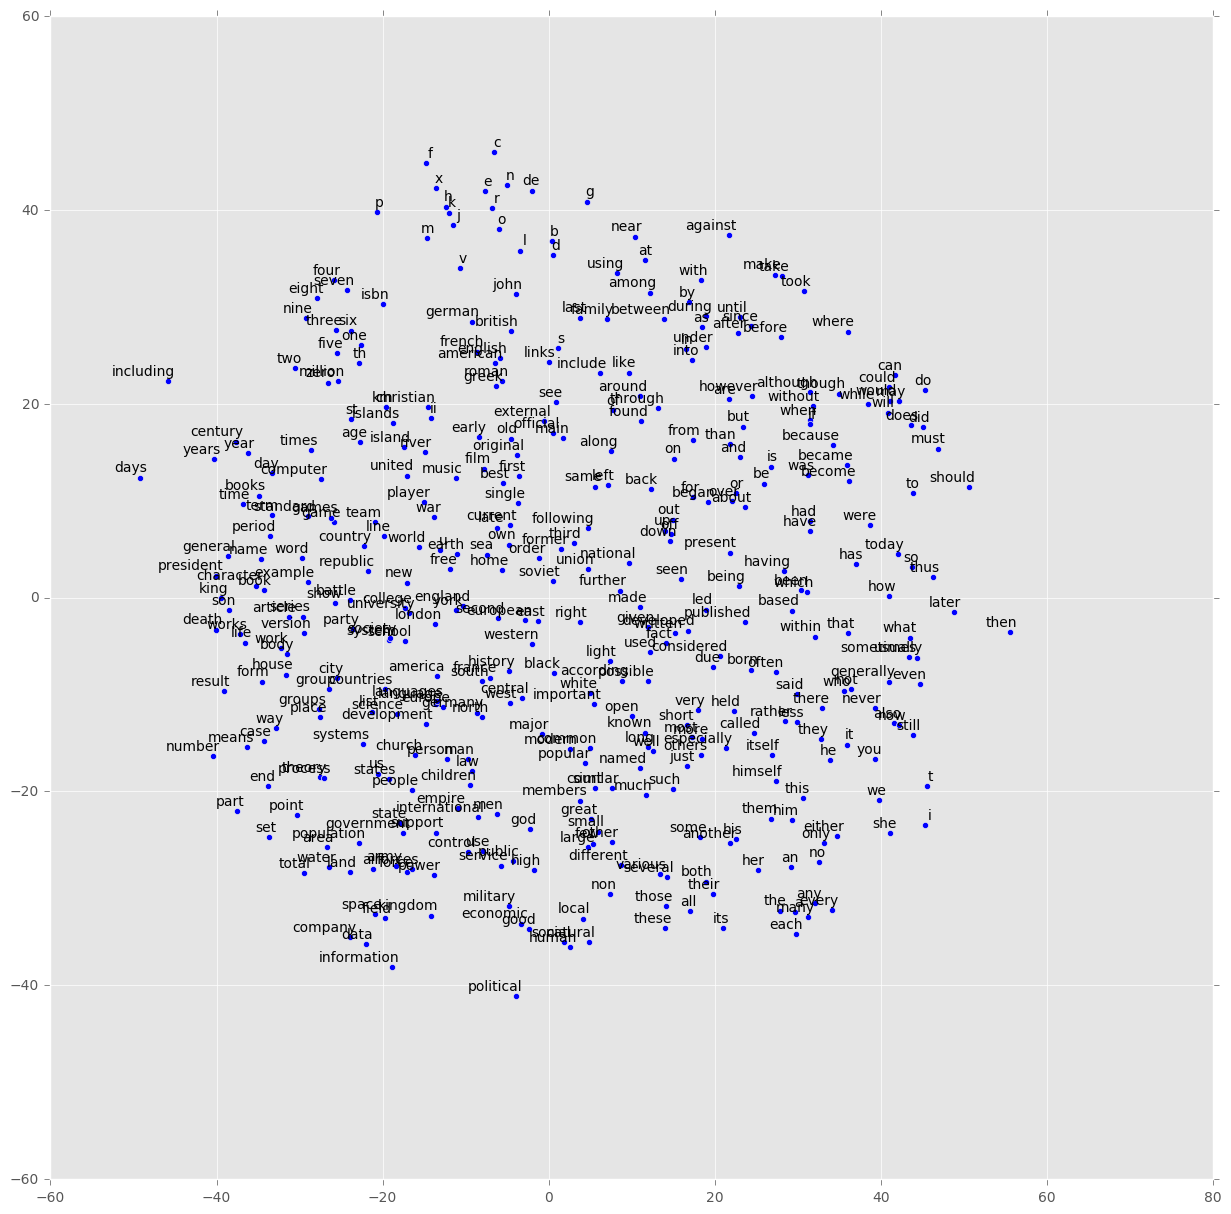

In [13]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    pylab.style.use('ggplot')
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [15]:
## Interesting experiment
idx_puppy, idx_dog, idx_cat, idx_kitten = dictionary['puppy'], dictionary['dog'], dictionary['cat'], dictionary['kitten']
vec = final_embeddings[[idx_puppy]] - final_embeddings[[idx_dog]] + final_embeddings[[idx_cat]]
print("w('puppy' - 'dog' + 'cat') dot w('kitten') =", np.dot(vec, final_embeddings[idx_kitten].T))

dvec = final_embeddings[idx_puppy] - final_embeddings[idx_dog]
cvec = final_embeddings[idx_kitten] - final_embeddings[idx_cat]
print("|'puppy' - 'dog'| = %f; |'kitten' - 'cat'| = %f" %(np.linalg.norm(dvec), np.linalg.norm(cvec)))

w('puppy' - 'dog' + 'cat') dot w('kitten') = [-0.07662452]
|'puppy' - 'dog'| = 1.422439; |'kitten' - 'cat'| = 1.351694


In [12]:
idx_father, idx_mother = dictionary['father'], dictionary['mother']
fmvec = final_embeddings[idx_father] - final_embeddings[idx_mother]
print("|'father' - 'mother'| = %f" %(np.linalg.norm(fmvec)))
print("w('father') dot w('mother') = %f" %(np.dot(final_embeddings[idx_father], final_embeddings[idx_mother].T)))

|'father' - 'mother'| = 1.059564
w('father') dot w('mother') = 0.438662


In [16]:
pkvec = final_embeddings[idx_puppy] - final_embeddings[idx_kitten]
dcvec = final_embeddings[idx_dog] - final_embeddings[idx_cat]
print("|'puppy' - 'kitten'| = %f; |'dog' - 'cat'| = %f" %(np.linalg.norm(pkvec), np.linalg.norm(dcvec)))

|'puppy' - 'kitten'| = 1.516163; |'dog' - 'cat'| = 1.424755


In [17]:
dkvec = final_embeddings[idx_dog] - final_embeddings[idx_kitten]
pcvec = final_embeddings[idx_puppy] - final_embeddings[idx_cat]
print("|'dog' - 'kitten'| = %f; |'puppy' - 'cat'| = %f" %(np.linalg.norm(dkvec), np.linalg.norm(pcvec)))

|'dog' - 'kitten'| = 1.404485; |'puppy' - 'cat'| = 1.191379


In [9]:
idx_man, idx_woman, idx_king, idx_queen = dictionary['man'], dictionary['woman'], dictionary['king'], dictionary['queen']
kmvec = final_embeddings[idx_king] - final_embeddings[idx_man]
qwvec = final_embeddings[idx_queen] - final_embeddings[idx_woman]
print("|'king' - 'man'| = %f; |'queen' - 'woman'| = %f" %(np.linalg.norm(kmvec), np.linalg.norm(qwvec)))

|'king' - 'man'| = 1.331044; |'queen' - 'woman'| = 1.409551


In [10]:
kqvec = final_embeddings[idx_king] - final_embeddings[idx_queen]
mwvec = final_embeddings[idx_man] - final_embeddings[idx_woman]
print("|'king' - 'queen'| = %f; |'man' - 'woman'| = %f" %(np.linalg.norm(kqvec), np.linalg.norm(mwvec)))

|'king' - 'queen'| = 1.237483; |'man' - 'woman'| = 0.965543


### Experiment using skip-gram

In [13]:
# Settings
batch_size = 128
embedding_size = 256  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64  # Number of negative examples to sample in softmax.


# Input data.
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Variables.
embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Model.
# Look up embeddings for inputs.
embed = tf.nn.embedding_lookup(embeddings, train_dataset)
# Compute the softmax loss, using a sample of the negative labels each time.
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

# Optimizer.
# Note: The optimizer will optimize the softmax_weights AND the embeddings.
# This is because the embeddings are defined as a variable quantity and the
# optimizer's `minimize` method will by default modify all variable quantities 
# that contribute to the tensor it is passed.
# See docs on `tf.train.Optimizer.minimize()` for more details.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [17]:
from time import time
num_steps = 100001

t0 = time()
session = tf.Session()
init = tf.initialize_all_variables()
session.run(init)

print('Initialized')
average_loss = 0
for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print('Average loss at step %d: %f' % (step, average_loss))
        average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
        sim = session.run(similarity)
        for i in range(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log = 'Nearest to %s:' % valid_word
            for k in range(top_k):
                close_word = reverse_dictionary[nearest[k]]
                log = '%s %s,' % (log, close_word)
            print(log)

final_embeddings = session.run(normalized_embeddings)
print('Elapsed training time:', time()-t0, 'seconds')

Initialized
Average loss at step 0: 7.437912
Nearest to not: lejeune, pulverized, weyl, hatching, edvard, judaic, finite, highlighted,
Nearest to years: stationary, zee, xi, archeologist, oud, myr, situations, heathen,
Nearest to th: mandel, drava, amplifies, ilya, wendell, adrenaline, fraud, iowa,
Nearest to used: tus, persecuting, desolate, linguistic, abstinence, nullification, matthias, categories,
Nearest to for: import, reza, reducing, defense, nelly, bad, expense, peyote,
Nearest to a: overseers, prophet, females, alibi, recipe, antiderivatives, nes, decidable,
Nearest to than: wissenschaften, coincides, wilford, sorority, breakaway, quantities, impression, getz,
Nearest to his: rewrites, galactic, digits, smolensk, agathon, garden, cdna, reputed,
Nearest to at: cheered, citing, tetragrammaton, baja, pitch, micrometres, winsor, once,
Nearest to no: analytical, estimator, dantzig, coercion, commonsense, nusa, rachael, shamanistic,
Nearest to after: est, vcs, hic, mauss, gaye, imp

In [18]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

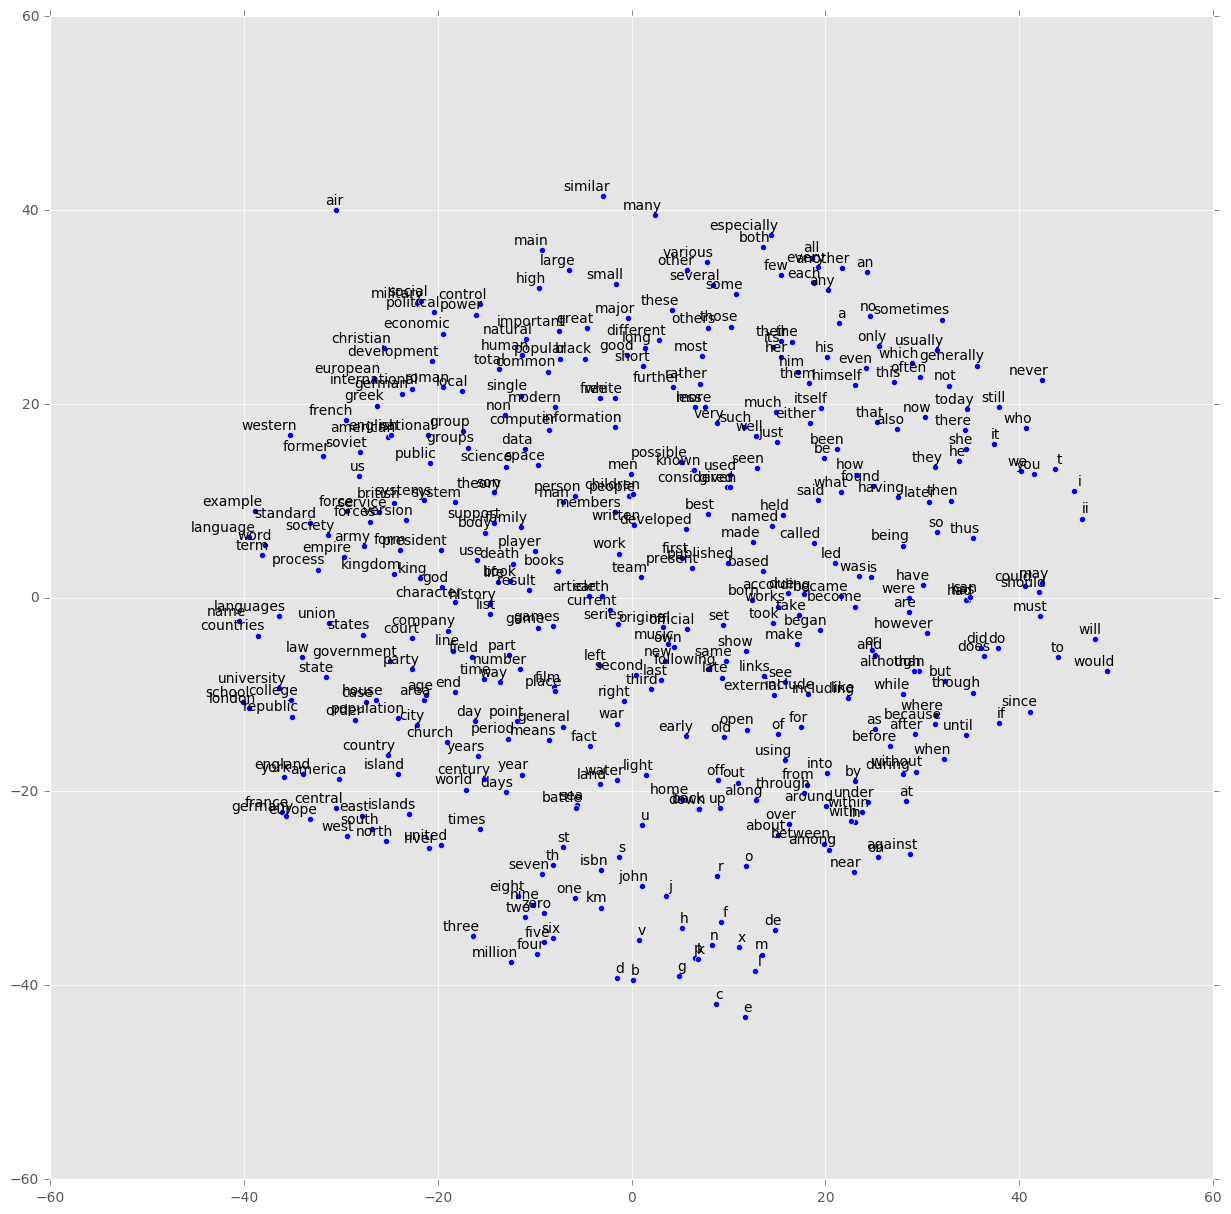

In [19]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    pylab.style.use('ggplot')
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [20]:
## Interesting experiment
idx_puppy, idx_dog, idx_cat, idx_kitten = dictionary['puppy'], dictionary['dog'], dictionary['cat'], dictionary['kitten']
vec = final_embeddings[[idx_puppy]] - final_embeddings[[idx_dog]] + final_embeddings[[idx_cat]]
print("w('puppy' - 'dog' + 'cat') dot w('kitten') =", np.dot(vec, final_embeddings[idx_kitten].T))

dvec = final_embeddings[idx_puppy] - final_embeddings[idx_dog]
cvec = final_embeddings[idx_kitten] - final_embeddings[idx_cat]
print("|'puppy' - 'dog'| = %f; |'kitten' - 'cat'| = %f" %(np.linalg.norm(dvec), np.linalg.norm(cvec)))

w('puppy' - 'dog' + 'cat') dot w('kitten') = [ 0.02267449]
|'puppy' - 'dog'| = 1.383410; |'kitten' - 'cat'| = 1.449783


In [21]:
idx_father, idx_mother = dictionary['father'], dictionary['mother']
fmvec = final_embeddings[idx_father] - final_embeddings[idx_mother]
print("|'father' - 'mother'| = %f" %(np.linalg.norm(fmvec)))
print("w('father') dot w('mother') = %f" %(np.dot(final_embeddings[idx_father], final_embeddings[idx_mother].T)))

|'father' - 'mother'| = 1.220859
w('father') dot w('mother') = 0.254752


In [22]:
pkvec = final_embeddings[idx_puppy] - final_embeddings[idx_kitten]
dcvec = final_embeddings[idx_dog] - final_embeddings[idx_cat]
print("|'puppy' - 'kitten'| = %f; |'dog' - 'cat'| = %f" %(np.linalg.norm(pkvec), np.linalg.norm(dcvec)))

|'puppy' - 'kitten'| = 1.324027; |'dog' - 'cat'| = 1.424405


In [23]:
dkvec = final_embeddings[idx_dog] - final_embeddings[idx_kitten]
pcvec = final_embeddings[idx_puppy] - final_embeddings[idx_cat]
print("|'dog' - 'kitten'| = %f; |'puppy' - 'cat'| = %f" %(np.linalg.norm(dkvec), np.linalg.norm(pcvec)))

|'dog' - 'kitten'| = 1.378502; |'puppy' - 'cat'| = 1.376273


In [24]:
idx_man, idx_woman, idx_king, idx_queen = dictionary['man'], dictionary['woman'], dictionary['king'], dictionary['queen']
kmvec = final_embeddings[idx_king] - final_embeddings[idx_man]
qwvec = final_embeddings[idx_queen] - final_embeddings[idx_woman]
print("|'king' - 'man'| = %f; |'queen' - 'woman'| = %f" %(np.linalg.norm(kmvec), np.linalg.norm(qwvec)))

|'king' - 'man'| = 1.308305; |'queen' - 'woman'| = 1.359294


In [25]:
kqvec = final_embeddings[idx_king] - final_embeddings[idx_queen]
mwvec = final_embeddings[idx_man] - final_embeddings[idx_woman]
print("|'king' - 'queen'| = %f; |'man' - 'woman'| = %f" %(np.linalg.norm(kqvec), np.linalg.norm(mwvec)))

|'king' - 'queen'| = 1.266346; |'man' - 'woman'| = 1.156830


---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [54]:
# Settings
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64  # Number of negative examples to sample in softmax.
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [56]:
from time import time
num_steps = 100001

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        # inverse data and labels from skip-gram method to CBOW method
        skgram_data, skgram_labels = generate_batch(
            batch_size, num_skips, skip_window)
        batch_data, batch_labels = skgram_labels.reshape(batch_size,), skgram_data.reshape(batch_size, 1)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
print('Elapsed training time:', time()-t0, 'seconds')

Initialized
Average loss at step 0: 7.632609
Nearest to and: nusa, luminosity, emirate, joannes, ode, electronica, theater, enz,
Nearest to th: consulate, lavos, feinstein, sweetened, radical, triage, launching, abjad,
Nearest to there: laurier, conformity, xa, estonians, striving, vacationing, reproductive, sonnets,
Nearest to three: cowdery, teletype, regret, solemnly, lems, deceive, nzenberg, furioso,
Nearest to can: boxer, monotremes, kramnik, conectiva, phimosis, mauro, risc, rebelled,
Nearest to s: mailing, assembly, vinton, roth, thompson, bukharin, disturbs, monotheistic,
Nearest to other: miriam, bypass, pretence, fc, haus, irr, rosser, burgesses,
Nearest to however: cheerleader, snatch, epstein, rarity, hurdles, aisle, glasses, cigars,
Nearest to but: univac, applying, despite, freiherr, calculators, palestinian, chrysotile, missionaries,
Nearest to a: ivan, semiarid, ides, diz, hieroglyphs, astounding, hams, irn,
Nearest to his: basics, remotely, displays, armageddon, costin

Average input vectors of CBOW method

In [8]:
# Settings
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1  # How many words to consider left and right.
num_skips = 2  # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64  # Number of negative examples to sample in softmax.
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    for i in range(batch_size/2):
        # obtain average word vectors
        if i==0:
            op_embed = tf.reshape(tf.reduce_mean(tf.gather(embed, np.arange(i*num_skips, i*num_skips+num_skips)), 0), (-1,embedding_size))
            continue
        context_avg = tf.reshape(tf.reduce_mean(tf.gather(embed, np.arange(i*num_skips, i*num_skips+num_skips)), 0), (-1,embedding_size))
        op_embed = tf.concat(0, [op_embed, context_avg])
    op_labels = tf.gather(train_labels, np.arange(0,batch_size,num_skips))
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, op_embed,
                               op_labels, num_sampled, vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [9]:
from time import time
num_steps = 100001

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        # inverse data and labels from skip-gram method to CBOW method
        skgram_data, skgram_labels = generate_batch(
            batch_size, num_skips, skip_window)
        batch_data, batch_labels = skgram_labels.reshape(batch_size,), skgram_data.reshape(batch_size, 1)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
print('Elapsed training time:', time()-t0, 'seconds')

Initialized
Average loss at step 0: 7.432557
Nearest to if: spectrometer, paracompact, swing, begin, ventricles, representationalism, easterners, landgrave,
Nearest to i: tore, unfolded, philadelphia, niro, verisign, daria, cabrera, wong,
Nearest to some: kilometers, glorious, repealed, grieg, scrolling, primer, mauna, arenas,
Nearest to is: cynics, predefined, abolishment, fiorello, detachment, elliot, confirmed, smog,
Nearest to nine: narn, budge, hamburger, pulleys, translating, viennese, gcb, cycling,
Nearest to used: mkultra, legislated, acacias, ciudad, honorius, coefficient, permeable, masochism,
Nearest to after: risc, retold, saved, cjd, bitola, blister, symbolic, contrived,
Nearest to known: glazed, norbert, moravian, flutter, changed, jazeera, projector, aldus,
Nearest to new: toppled, insensitive, sewing, usefully, transpired, lugo, html, cacti,
Nearest to first: sayles, hamilton, pretenders, ecological, edmunds, charge, savory, scatter,
Nearest to on: therus, cycling, vide